# Imports

In [1]:
import datetime
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import shap

# Configs

## Constant Values

In [2]:
INPUT_PATH = 'datasets/'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

feature_list = ['prev_month_demand', 'prev_2week_demand', 'prev_week_demand', 'prev_day_demand', 
                'pre_min_week_demand', 'pre_max_week_demand', 'pre_mean_week_demand', 
                'pre_std_week_demand', 'month', 'day_month', 'day_week']

test_size_ratio = 0.25

# Data preparation


## Load Data

In [3]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [4]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [35]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672629, 3)


,tpep_pickup_datetime,PULocationID,PU_date
0,2023-01-01 00:32:10,161,2023-01-01
1,2023-01-01 00:55:08,43,2023-01-01
2,2023-01-01 00:25:04,48,2023-01-01
3,2023-01-01 00:03:48,138,2023-01-01
4,2023-01-01 00:10:29,107,2023-01-01


## Labeling

In [5]:
def labeling(dataset):
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['Location', 'Date'])
        .fillna(value=0)
    )

    return labels_df


In [6]:
labeled_df = labeling(rides_df)

In [38]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


## Add Feature

In [39]:
def add_features(data):  # run after merging datasets and modifing date
    # Lag features
    data['prev_day_demand'] = data.groupby(['Location'])['Demand'].shift(1)
    data['prev_week_demand'] = data.groupby(['Location'])['Demand'].shift(7)
    data['prev_2week_demand'] = data.groupby(['Location'])['Demand'].shift(14)
    data['prev_month_demand'] = data.groupby(['Location'])['Demand'].shift(28)

    # Summary features
    window = data['Demand'].rolling(window = 7)
    data['pre_min_week_demand'] = window.min()
    data['pre_mean_week_demand'] = window.mean()
    data['pre_max_week_demand'] = window.max()
    data['pre_std_week_demand'] = window.std()
    
    data = data.dropna()

    return data

In [40]:
features_df = add_features(labeled_df)

In [41]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (24104, 11)


,Location,Date,Demand,prev_day_demand,prev_week_demand,prev_2week_demand,prev_month_demand,pre_min_week_demand,pre_mean_week_demand,pre_max_week_demand,pre_std_week_demand
28,1,2023-01-29,12.0,6.0,11.0,19.0,40.0,6.0,8.142857,13.0,3.023716
29,1,2023-01-30,14.0,12.0,6.0,21.0,31.0,6.0,9.285714,14.0,3.545621
30,1,2023-01-31,8.0,14.0,6.0,18.0,27.0,6.0,9.571429,14.0,3.309438
31,1,2023-02-01,9.0,8.0,7.0,10.0,7.0,6.0,9.857143,14.0,3.132016
32,1,2023-02-02,18.0,9.0,7.0,9.0,15.0,6.0,11.428571,18.0,4.076647


## Extract Calendar features

In [42]:
def add_calendar_features(data):  # Year/Month/Day
    data['month'] = data['Date'].dt.month
    data['day_month'] = data['Date'].dt.day
    data['day_week'] = data['Date'].dt.dayofweek

    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [43]:
date_features_df = add_calendar_features(features_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [44]:
print(f'date_features dataframe shape : {date_features_df.shape}')
date_features_df.head()

date_features dataframe shape : (24104, 15)


,Location,Date,Demand,prev_day_demand,prev_week_demand,prev_2week_demand,prev_month_demand,pre_min_week_demand,pre_mean_week_demand,pre_max_week_demand,pre_std_week_demand,month,day_month,day_week,day_year
28,1,2023-01-29,12.0,6.0,11.0,19.0,40.0,6.0,8.142857,13.0,3.023716,1,29,6,0
29,1,2023-01-30,14.0,12.0,6.0,21.0,31.0,6.0,9.285714,14.0,3.545621,1,30,0,1
30,1,2023-01-31,8.0,14.0,6.0,18.0,27.0,6.0,9.571429,14.0,3.309438,1,31,1,2
31,1,2023-02-01,9.0,8.0,7.0,10.0,7.0,6.0,9.857143,14.0,3.132016,2,1,2,3
32,1,2023-02-02,18.0,9.0,7.0,9.0,15.0,6.0,11.428571,18.0,4.076647,2,2,3,4


## Split Train and Test Data

In [60]:
def train_test_splitting(dataset, test_size):
    start_date = dataset['Date'].min()
    end_date = dataset['Date'].max()
    all_days = end_date - start_date

    train_df = dataset[(dataset['Date'] - start_date) < (1 - test_size) * all_days]
    test_df = dataset[(dataset['Date'] - start_date) >= (1 - test_size) * all_days]

    return train_df, test_df

In [61]:
train_df, test_df = train_test_splitting(date_features_df, test_size_ratio)

In [62]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (18078, 15)


,Location,Date,Demand,prev_day_demand,prev_week_demand,prev_2week_demand,prev_month_demand,pre_min_week_demand,pre_mean_week_demand,pre_max_week_demand,pre_std_week_demand,month,day_month,day_week,day_year
28,1,2023-01-29,12.0,6.0,11.0,19.0,40.0,6.0,8.142857,13.0,3.023716,1,29,6,0
29,1,2023-01-30,14.0,12.0,6.0,21.0,31.0,6.0,9.285714,14.0,3.545621,1,30,0,1
30,1,2023-01-31,8.0,14.0,6.0,18.0,27.0,6.0,9.571429,14.0,3.309438,1,31,1,2
31,1,2023-02-01,9.0,8.0,7.0,10.0,7.0,6.0,9.857143,14.0,3.132016,2,1,2,3
32,1,2023-02-02,18.0,9.0,7.0,9.0,15.0,6.0,11.428571,18.0,4.076647,2,2,3,4


In [63]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (6026, 15)


,Location,Date,Demand,prev_day_demand,prev_week_demand,prev_2week_demand,prev_month_demand,pre_min_week_demand,pre_mean_week_demand,pre_max_week_demand,pre_std_week_demand,month,day_month,day_week,day_year
97,1,2023-04-08,14.0,7.0,13.0,15.0,14.0,7.0,12.428571,18.0,4.117327,4,8,5,69
98,1,2023-04-09,18.0,14.0,17.0,14.0,20.0,7.0,12.571429,18.0,4.314979,4,9,6,70
99,1,2023-04-10,17.0,18.0,9.0,3.0,13.0,7.0,13.714286,18.0,4.270608,4,10,0,71
100,1,2023-04-11,14.0,17.0,12.0,14.0,14.0,7.0,14.000000,18.0,4.203173,4,11,1,72
101,1,2023-04-12,16.0,14.0,18.0,7.0,5.0,7.0,13.714286,18.0,3.946065,4,12,2,73


# Model Training

## **Gradient Boosting Regressor**

### Model Tuning

In [26]:
def grid_search(model, test_parameters, train_data, feature_list, cv = None):
    gs = GridSearchCV(estimator = model, param_grid = test_parameters, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs = -1)
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [ ]:
param_test = {'max_depth':range(2,10,2), 'min_child_weight':range(1,6,2)}

params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'n_estimators':140, 'learning_rate':0.1, 'max_depth':5,
         'min_child_weight':1, 'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8, 'seed':27}

best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test,
                                      train_data = train_df, feature_list = feature_list, cv = 5)
print(best_params, best_score)

{'max_depth': 2, 'min_child_weight': 3} -129.96563188441945


In [ ]:
params.update(best_params)
param_test = {'gamma':[i/10.0 for i in range(0,5)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, 
                                      train_data = train_df, feature_list = feature_list, cv = 5)
print(best_params, best_score)

{'gamma': 0.0} -238.60198873503435


In [ ]:
params.update(best_params)
param_test = {'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, 
                                      train_data = train_df, feature_list = feature_list, cv = 5)
print(best_params, best_score)

{'colsample_bytree': 0.6, 'subsample': 0.9} -237.0204546297031


In [ ]:
params.update(best_params)
param_test = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, 
                                      train_data = train_df, feature_list = feature_list, cv = 5)
print(best_params, best_score)

{'reg_alpha': 1} -237.02005974356038


In [ ]:
params.update(best_params)
param_test = {'n_estimators':list(range(1000, 5001, 500)), 'learning_rate':[0.01]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, 
                                      train_data = train_df, feature_list = feature_list, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.01, 'n_estimators': 1500} -236.59626847393665


In [ ]:
params.update(best_params)
param_test = {'n_estimators':list(range(15000, 20001, 500)), 'learning_rate':[0.001]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, 
                                      train_data = train_df, feature_list = feature_list, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.001, 'n_estimators': 15000} -236.53642284774014


### Prediction

In [64]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    
    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [65]:
params = {'learning_rate': 0.001, 'n_estimators': 15000, 'reg_alpha': 1, 'colsample_bytree': 0.6,
          'subsample': 0.9, 'gamma': 0.0, 'max_depth': 2, 'min_child_weight': 5}
model = xgb.XGBRegressor(**params)
yhat_train, yhat_test = model_predict(model, train_df, test_df, feature_list)

### Visualization

In [66]:
def prediction_visualization(train_data, test_data, yhat_train, yhat_test):

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = yhat_train
    predicted_test_df['Predicted'] = yhat_test

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


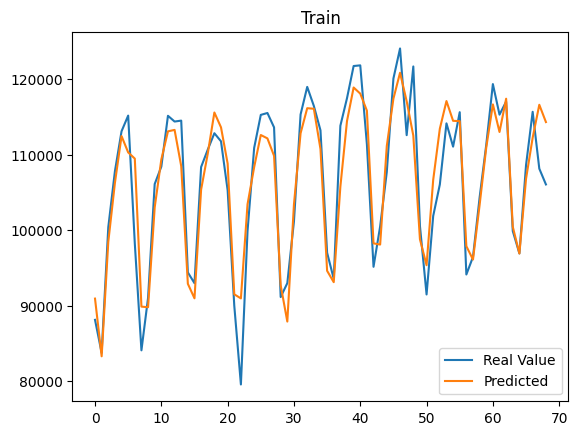

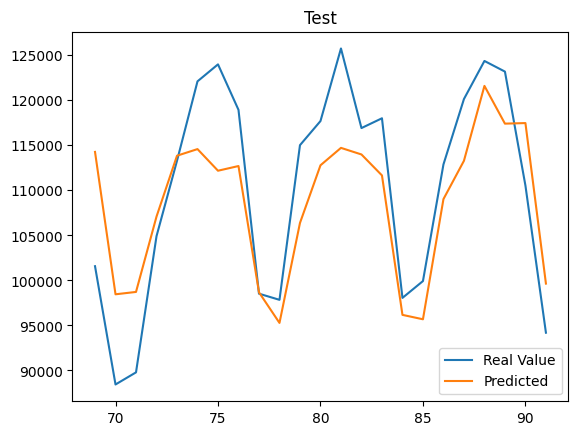

In [67]:
prediction_visualization(train_df, test_df, yhat_train, yhat_test)

### Evaluation

In [68]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [69]:
def evaluation(model_name, train_data, test_data, yhat_train, yhat_test):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], yhat_train)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], yhat_train)

    print(f'{model_name} test scores:')


    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], yhat_test)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], yhat_test)


In [70]:
evaluation('XGB', train_df, test_df, yhat_train, yhat_test)  # for whole data

XGB train scores:
MAE : 27.02053685276128
MSE : 6500.939912796847
XGB test scores:
MAE : 34.63029768690096
MSE : 10696.268056111836


### Feature Importance and SHAPE

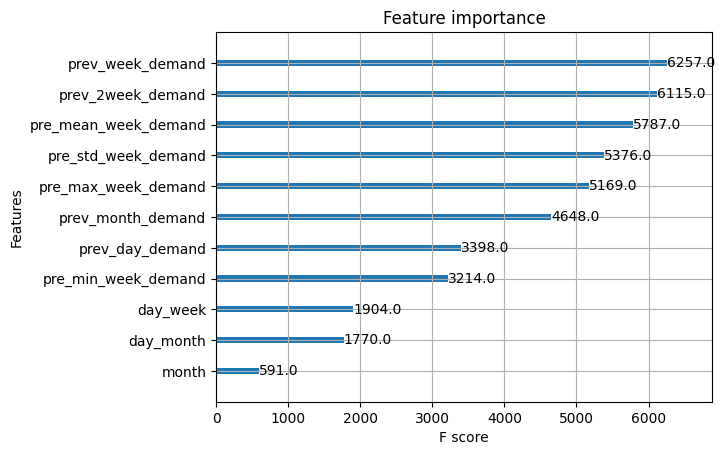

In [57]:
xgb.plot_importance(model)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


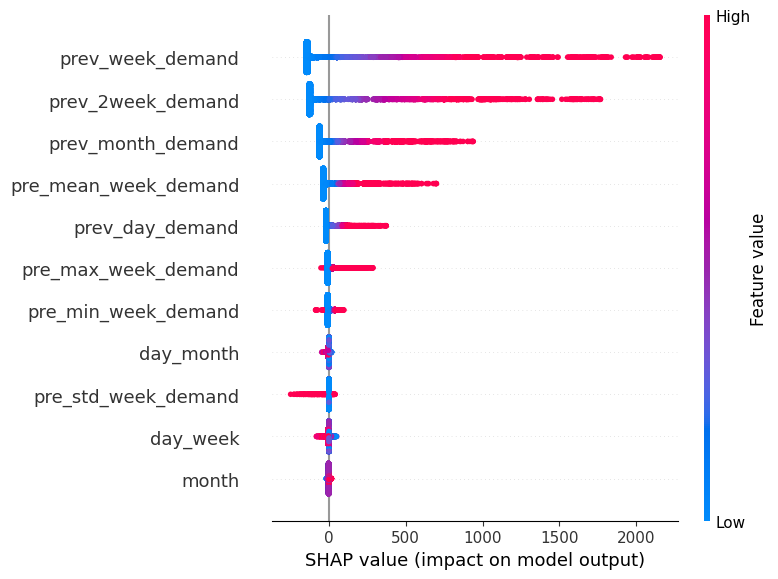

In [58]:
dtrain_reg = xgb.DMatrix(train_df[feature_list].values, train_df['Demand'].values, enable_categorical=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain_reg)
shap.summary_plot(shap_values, train_df[feature_list])